### Vibration of membranes under tension

In the previous lecture, I discussed time-dependent diffusion problem. It was a parabolic PDE. Now, I will discuss vibration in Membranes. This problem, at the simplest level, takes the form:

\begin{align}
\rho {\partial^2 \over \partial t^2} w(x, y, t) &= T \nabla^2 w(x, y, t) + f(x, y, t)\;\;\;\;\mbox{domain (circle of radius 1)}\\
w(x, y, 0) &= 0\;\;\;\;\;\mbox{ at the boundary the membrane is fixed}\\
w(x, y, 0) &= w_0(x, y)\;\;\;\mbox{initial displacement}\\
{\partial \over \partial t}w(x, y, t)\left . \right\vert_{t = 0} &= v_0(x, y)\;\;\;\mbox{initial velocity}
\end{align}

Note that we require two initial conditions, one each in displacement and velocity. 
In the problem that we solve below, we will use initial displacement and velocity profile as zero, i.e., $w_0(x, y) = v_0(x, y) = 0$. Note that $\rho$ is density per unit area and $T$ is the tension in the membrane. The quantity $\sqrt{{T \over \rho}} = c$,which is the wave speed in the membrane. We will hence, for simplicity, replace the main differential equation with a more compact version

$$ {\partial^2 \over \partial t^2} w(x, y, t) = c^2 \nabla^2 w(x, y, t) + f(x, y, t),$$

where, we apply oscillatory, loading of the form:
$$f(x, y, t) = \epsilon \exp \left(-\frac{x^2 + y^2}{2\sigma^2} \right)\cos \omega t.$$
The loading is centered about $x = y = 0$ and oscillates with frequency $\omega$, and $\epsilon$ is the magnitude of the load. 

Such PDEs with second order derivative in time are called as hyperbolic and the numerical techniques that are required need to be more sophisticated (look at the book by [Seshu](https://www.amazon.in/Textbook-Finite-Element-Analysis-Seshu/dp/8120323157/ref=sr_1_1?crid=24AHCDSKIUX56&dchild=1&keywords=finite+element+analysis+p+seshu&qid=1585123865&sprefix=Seshu+finite%2Caps%2C268&sr=8-1)). We will follow a simple rule -- extension of the Crank-Nicholson rule, and can be also thought of approximately as [mid-point Euler](https://en.wikipedia.org/wiki/Midpoint_method) scheme, or Trapezoidal rule. As described below, Newmark's scheme (or its variations) are demonstrably better (see the following [demo](https://comet-fenics.readthedocs.io/en/latest/demo/elastodynamics/demo_elastodynamics.py.html) or the book by [K. J. Bathe](https://www.amazon.in/Finite-Element-Procedures-United-States/dp/0133014584/ref=sr_1_1?dchild=1&keywords=finite+element+procedures&qid=1585124041&sr=8-1)). 

Our simple scheme is as follows. We use the notation $w$ and ${\partial w \over \partial t} = v$ (`wdot` or velocity of the membrane.) With this notation, the scheme is:
\begin{align}
{w^{t + \Delta t} - w^t \over \Delta t} &= {1\over 2}\left(v^{t+\Delta t} + v^t \right),\\
{v^{t + \Delta t} - v^t \over \Delta t} &= {c^2 \over 2}\left(\nabla^2 w^{t+\Delta t} + \nabla^2 w^t \right) + f(x,y,t+{\Delta t \over 2}),
\end{align}
where the forcing term is evaluated at $t + \Delta t/2$. We can manipulate these two equations to provide us with two equations in terms of $w^{t + \Delta t}$ and $v^{t + \Delta t}$ as follows:
\begin{align}
w^{t + \Delta t} &= w^t + v^t\Delta t  + {c^2 \Delta t^2 \over 4}\left(\underbrace{\nabla^2 w^{t+\Delta t}}_{\ddot{u}^{t+\Delta t}} + \underbrace{\nabla^2 w^t}_{\ddot{u}^{t}} \right) + {c^2 \Delta t^2 \over 2}f(x,y,t+{\Delta t \over 2}),\\
v^{t + \Delta t} &= 2 {w^{t + \Delta t} - w^t \over \Delta t} + v^t
\end{align}
Thus we can start with the initial conditions for $w^0$ and $v^0$. Solve the above equation using the following weak form (similar to what we did for heat diffusion problem)

$$\int_\Omega w^{t+\Delta t} \delta w d\Omega - \int_\Omega w^t \delta \Omega - \Delta t \int_\Omega v^t \delta w d\Omega + {c^2 \Delta t^2 \over 4} \int_{\Omega} (\nabla w^{t+\Delta t} + \nabla w^t)\cdot \nabla \delta w d\Omega - {c^2 \Delta t^2 \over 2} \int_\Omega f(x, y, t + {t \over 2})\delta w d\Omega = 0,
$$

to obtain $w^{\Delta t}$, which we use to update $v^{t + \Delta t}$. The solution is thus propagated.  

Note that after the finite element analysis you actually get a following equation:
$$[M]\{\ddot{u}\} + [K]\{ u\} = \{F(t)\},$$
where:
\begin{align}
[M] &= \int_{\Omega} \{N\}\langle N \rangle d\Omega,\\
[K] &=\int_{\Omega}   c^2 \{B\}\langle B \rangle d\Omega,\\
\{F\} &=  \int_\Omega \{N\} f(x, y, t) d\Omega.
\end{align}
We can explicity get these matrices in FEniCS and then potentially add damping terms, and also create more __efficient__ numerical schemes as shown in the [elastodynamics demo](https://comet-fenics.readthedocs.io/en/latest/demo/elastodynamics/demo_elastodynamics.py.html). However, to demonstrate the concept, we perform a simpler analysis as demonstrated below.

#### FEniCS demo
Load libraries, define the parameters of the simulations, and create a circular domain centered around the origin and having radius of 1. The domain has radius of 1. 

In [ ]:
from __future__ import print_function
from dolfin import *
import numpy as np
import mshr
import matplotlib.pyplot as plt
%matplotlib inline


T = 20.0            # final time
num_steps = 1000     # number of time steps
dt = T / num_steps # time step size
c = 1.0 # wave speed in the material
PI = np.pi # defining PI as a parameter
epsilon = 0.05 # amplitude of the forcing
omega = 2.0 # frequency of oscillation
sig = 0.05 # width of Gaussian of the forcing


Nmesh = 50
domain = mshr.Circle(Point(0,0), 1)
mesh = mshr.generate_mesh(domain, Nmesh)
plot(mesh)

Define relevant functions spaces on the mesh and the initial conditions for displacement `w` and velocity `wdot`. Define the boundary conditions. 

In [ ]:
# Define functionspace
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
w_D = Constant(0.)

# Define initial value
w_n = interpolate(Constant(0.0), V)
wdot_n = interpolate(Constant(0.0), V) # initial velocity is given to be zero

# Define boundary conditions
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, w_D, boundary)

As in the case of the heat equation, define the variational problem. 

In [ ]:
# Define variational problem
w = TrialFunction(V)
wdot = TrialFunction(V)
v = TestFunction(V)

# External
f_ext = Expression('epsilon*exp(-(x[0]*x[0] + x[1]*x[1])/(2*sig*sig))*cos(omega*t)', \
                   degree = 2, epsilon = epsilon, omega = omega, sig = sig, t = dt/2.)

# using Crank-Nicholson scheme
F = w*v*dx - w_n*v*dx - dt*wdot_n*v*dx - \
    c*c*dt*dt/2*f_ext*v*dx + \
    c*c*dt*dt/2./2.*(inner(grad(w),grad(v)) + inner(grad(w_n), grad(v)))*dx
a, L = lhs(F), rhs(F)

Begin the update for the variational form. Save .pvd file for paraview. Also obtain elastic and kinetic energy. The initial variable `w_n` and `wdot_n` is now updated to carry the new value `w` and `wdot`. The process continues. The interplay is between the rate of oscillatory loading $\omega$ and the speed of wave $c$, which depends on tension and density of the membrane. 

In [ ]:
# start the update
# Time-stepping
file = File("./Membrane/Displacement.pvd", "compressed")

w = Function(V)
wdot = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    f_ext.t = t

    # Compute solution
    solve(a == L, w, bc)
    
    # update velocity
    wdot.vector()[:] = 2*(w.vector() - w_n.vector())/dt - wdot_n.vector()

    E_kin = 0.5*c*c*assemble(wdot*wdot*dx)
    E_elas = 0.5*assemble(inner(grad(w),grad(w))*dx)
    E_tot = E_elas + E_kin
    # Plot solution
    #plot(w)
    #plt.pause(0.5)

    # Update previous solution
    w_n.assign(w)
    wdot_n.assign(wdot)
    
    if (np.mod(n,10) == 0):
        file << (w, t)
        print("Elastic energy is ", E_elas)

The __complete__ code is given here, and can be run as a python file. 

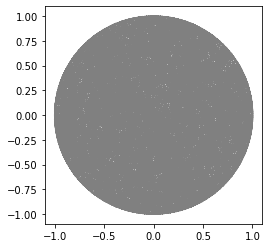

In [51]:
from __future__ import print_function
from dolfin import *
import numpy as np
import mshr
import matplotlib.pyplot as plt
%matplotlib inline


T = 20.0            # final time
num_steps = 1000     # number of time steps
dt = T / num_steps # time step size
c = 0.2 # wave speed in the material
PI = np.pi # defining PI as a parameter
epsilon = 5 # amplitude of the forcing
omega = 0.1 # frequency of oscillation
sig = 0.05 # width of Gaussian of the forcing
#eps2 = 0.1

Nmesh = 50
domain = mshr.Circle(Point(0,0), 1)
mesh = mshr.generate_mesh(domain, Nmesh)
plot(mesh)

# Define functionspace
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
w_D = Constant(0.)

# Define initial value
#w_exp = Expression("cos(PI*sqrt(x[0]*x[0]+x[1]*x[1]))", eps2 = eps2, PI = PI, degree = 2)
#w_n = interpolate(w_exp, V)
w_n = interpolate(Constant(0.0), V)
wdot_n = interpolate(Constant(0.0), V) # initial velocity is given to be zero

# Define boundary conditions
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, w_D, boundary)

# Define variational problem
w = TrialFunction(V)
wdot = TrialFunction(V)
v = TestFunction(V)

# External
f_ext = Expression('epsilon*exp(-(x[0]*x[0] + x[1]*x[1])/(2*sig*sig))*cos(omega*t)', \
                   degree = 2, epsilon = epsilon, omega = omega, sig = sig, t = dt/2.)

# using Crank-Nicholson scheme
F = w*v*dx - w_n*v*dx - dt*wdot_n*v*dx - \
    c*c*dt*dt/2*f_ext*v*dx + \
    c*c*dt*dt/4.*(inner(grad(w),grad(v)) + inner(grad(w_n), grad(v)))*dx
a, L = lhs(F), rhs(F)

# start the update
# Time-stepping
file = File("./Membrane2/Displacement.pvd", "compressed")
filev = File("./Membrane2/Velocity.pvd", "compressed")

w = Function(V)
wdot = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    f_ext.t = t + dt/2

    # Compute solution
    solve(a == L, w, bc)
    
    # update velocity
    wdot.vector()[:] = 2*(w.vector() - w_n.vector())/dt - wdot_n.vector()
    

    E_kin = 0.5*assemble(wdot*wdot*dx)
    E_elas = 0.5*c*c*assemble(inner(grad(w),grad(w))*dx)
    E_tot = E_elas + E_kin
    # Plot solution
    #plot(w)
    #plt.pause(0.5)

    # Update previous solution
    w_n.assign(w)
    wdot_n.assign(wdot)
    if (np.mod(n,10) == 0):
        file << (w, t)
        filev << (wdot, t)
        #print("Elastic energy is ", E_elas)

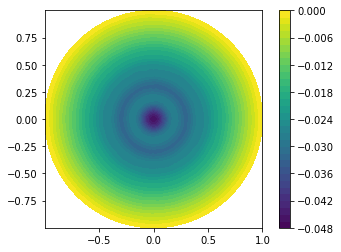

In [42]:
c = plot(wdot)
import matplotlib.pyplot as plt
plt.colorbar(c)

The video generated from [Paraview](https://www.paraview.org) is also attached. 